In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,mean_absolute_error
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('Dataset/data.csv')

In [3]:
df = df[~(df.values.ravel() == -1).reshape(df.shape).any(1)]

In [4]:
X = df.drop(columns='Trees')
y = df['Trees']

In [5]:
best_feature_mse = ['Shrubs', 'Peren_FG', 'bare_groun', 'Annual_FG', 'vpdmax', 'tmean',
       'slope', 'Runoff', 'Flooding_F', 'BD_depth']

In [6]:
best_df = df[best_feature_mse]

In [7]:
X = np.array(best_df)
y = np.array(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape

(2604, 10)

In [10]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
%%time
pca = PCA(n_components=0.95)

pca.fit(X_train)

Wall time: 2.99 ms


PCA(n_components=0.95)

In [40]:
print("Numberof Principle Components: ", pca.n_components_)  

np.sum(pca.explained_variance_ratio_)

Numberof Principle Components:  9


0.9757100720377053

In [41]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [42]:
X_test_pca.shape

(651, 9)

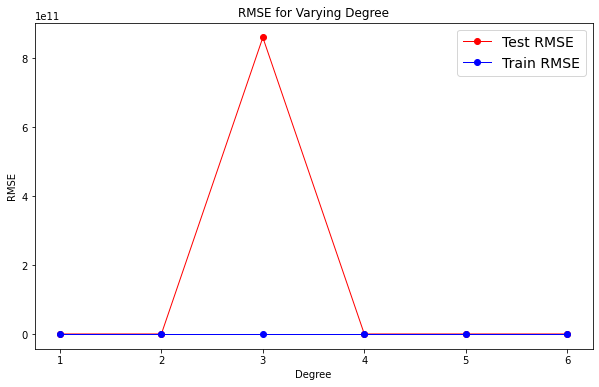


Optimal Degree:  2


In [43]:
degreeList = [1,2,3,4,5,6]


mse_train, mse_test = [], []

for degree in degreeList:

    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    model.fit(X_train, y_train)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    
    mse_train.append(mean_squared_error(y_train, y_train_predicted))
    mse_test.append(mean_squared_error(y_test, y_test_predicted))
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE") 
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of optimal degree for the polynomial that gives smallest RMSE

rmse_test = np.sqrt(mse_test)
j = 0
min_rmse = rmse_test[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_test[j] < min_rmse):
        min_rmse = rmse_test[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

In [44]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

In [45]:
print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

No. of Original Features:  10
No. of Augmented Features:  65


## Ridge Regression

In [55]:
%%time


# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

param_grid = {'alpha': np.linspace(0.01, 1.0, num=40), 
              'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga"]}

ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train_poly, y_train)


params_optimal_ridge = ridge_cv.best_params_

print("Best Score (negative mean squared error): %f" % ridge_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_ridge)
print("\n")

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.4s


Best Score (negative mean squared error): -31.456177
Optimal Hyperparameter Values:  {'alpha': 0.9492307692307692, 'solver': 'sparse_cg'}


Wall time: 18.5 s


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   18.3s finished


In [56]:
# Ridge Regression


# Optimal model parameters
ridge_alpha = ridge_cv.best_params_['alpha']
print("Optimal alpha: ", ridge_alpha)

ridge_solver = ridge_cv.best_params_['solver']
print("Optimal alpha: ", ridge_solver)


# Create Ridge linear regression object
lin_reg_ridge = Ridge(alpha=ridge_alpha, solver=ridge_solver)

# Train the model
lin_reg_ridge.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_ridge = lin_reg_ridge.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_ridge))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_ridge))

Optimal alpha:  0.9492307692307692
Optimal alpha:  sparse_cg

----------------------------- Model Evaluation -----------------------------

Mean squared error: 27.85
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.76


In [57]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_ridge.predict(X_test_poly)


ridge_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % ridge_test_mse)



ridge_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % ridge_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 31.09
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.68


In [66]:

%%time


# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values

#param_grid = {'alpha': np.linspace(10.0, 20.0, num=10)}
param_grid = {'alpha': np.linspace(10,40,num=100)}

lasso = Lasso()

lasso_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train_poly, y_train)

params_optimal_lasso = lasso_cv.best_params_

print("Best Score (negative mean squared error): %f" % lasso_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_lasso)
print("\n")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Best Score (negative mean squared error): -31.422643
Optimal Hyperparameter Values:  {'alpha': 30.303030303030305}


Wall time: 1.04 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [67]:
# Lasso Regression

# Optimal model parameters
lasso_alpha = lasso_cv.best_params_['alpha']
print("Optimal alpha: ", lasso_alpha)


# Create Lasso linear regression object
lin_reg_lasso = Ridge(alpha=lasso_alpha)

# Train the model
lin_reg_lasso.fit(X_train_poly, y_train)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_lasso = lin_reg_lasso.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_lasso))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_lasso))

Optimal alpha:  30.303030303030305

----------------------------- Model Evaluation -----------------------------

Mean squared error: 27.87
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.76


In [68]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_lasso.predict(X_test_poly)

lasso_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % lasso_test_mse)


# Explained variance score: 1 is perfect prediction

lasso_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % lasso_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 30.95
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.68


In [71]:

%%time


# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal", "invscaling"], 
              'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],'eta0': [0.01, 0.001],
              'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}



sgd = SGDRegressor()

sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=2, n_jobs=-1)
sgd_cv.fit(X_train, y_train)


params_optimal_sgd = sgd_cv.best_params_

print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 8572 tasks      | elapsed:   13.2s


Best Score (negative mean squared error): -36.547884
Optimal Hyperparameter Values:  {'alpha': 0.001, 'eta0': 0.01, 'l1_ratio': 0.5, 'learning_rate': 'invscaling', 'loss': 'squared_epsilon_insensitive', 'max_iter': 400}


Wall time: 19.3 s


[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:   19.1s finished


In [72]:
# SGD Regression

# Create SGDRegressor linear regression object using the optimal hyperparameter values
lin_reg_sgd = SGDRegressor(**params_optimal_sgd)

# Train the model
lin_reg_sgd.fit(X_train, y_train)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_sgd = lin_reg_sgd.predict(X_train)


print("Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_sgd))


----------------------------- Model Evaluation -----------------------------
Mean squared error: 36.29
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.69


In [73]:

# Scoring Parameter for Regression:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

scores = cross_val_score(lin_reg_sgd, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(scores)

print("Negative Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-34.5274389  -44.65013497 -52.3007541  -30.0873304  -33.73740282
 -40.6077716  -40.7134409  -26.54409395 -32.77500768 -36.15402762]
Negative Mean Squared Error: -37.21 (+/- 14.30)


In [74]:
y_test_predicted = lin_reg_sgd.predict(X_test)


test_mse_linear = mean_squared_error(y_test, y_test_predicted)

print("Mean squared error: %.2f"
      % test_mse_linear)


# Explained variance score: 1 is perfect prediction
test_r2_linear = r2_score(y_test, y_test_predicted)
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % test_r2_linear)

Mean squared error: 35.47
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.63


In [75]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 2


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)


print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

No. of Original Features:  10
No. of Augmented Features:  65


In [76]:
%%time


# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
# param_grid = {'alpha': [0.1, 0.01], 'learning_rate': ["invscaling"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 5000],'eta0': [0.01, 0.001, 0.0001]}


param_grid = {'alpha': [0.1, 0.01], 'learning_rate': ["invscaling"], 
              'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],'eta0': [0.01, 0.001, 0.0001],
              'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}



sgd = SGDRegressor()

sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=2, n_jobs=-1)
sgd_cv.fit(X_train_poly, y_train)


params_optimal_sgd = sgd_cv.best_params_

print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1629 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 3453 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3825 out of 3840 | elapsed:  1.6min remaining:    0.3s


Best Score (negative mean squared error): -31.909812
Optimal Hyperparameter Values:  {'alpha': 0.01, 'eta0': 0.001, 'l1_ratio': 0.5, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'max_iter': 1000}


Wall time: 1min 40s


[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  1.7min finished


In [77]:

# SGD Regression

# Create SGDRegressor linear regression object using the optimal hyperparameter values
lin_reg_sgd = SGDRegressor(**params_optimal_sgd)

# Train the model
lin_reg_sgd.fit(X_train_poly, y_train)


# # The intercept
# print("Intercept: \n", lin_reg_sgd.intercept_)

# # The coefficients
# print("Coefficients: \n", lin_reg_sgd.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_sgd.n_iter_)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_sgd = lin_reg_sgd.predict(X_train_poly)


print("Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_sgd))

Number of Iterations: 
 94

----------------------------- Model Evaluation -----------------------------
Mean squared error: 28.22
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.76


In [78]:
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)

# Make prediction using the test data
y_test_predicted = lin_reg_sgd.predict(X_test_poly)

test_mse_polynomial = mean_squared_error(y_test, y_test_predicted)

print("Mean squared error: %.2f"
      % test_mse_polynomial)



# Explained variance score: 1 is perfect prediction

test_r2_polynomial = r2_score(y_test, y_test_predicted)
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % test_r2_polynomial)

Mean squared error: 31.31
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.68


In [79]:
data = [["MSE (test)", test_mse_linear, test_mse_polynomial], 
        ["R2 Score (test)", test_r2_linear, test_r2_polynomial]]
pd.DataFrame(data, columns=["Metric", "SGD Linear Regression", "SGD Polynomial Regression (degree 2)"])

,Metric,SGD Linear Regression,SGD Polynomial Regression (degree 2)
0,MSE (test),35.472754,31.310358
1,R2 Score (test),0.633114,0.676164


In [16]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

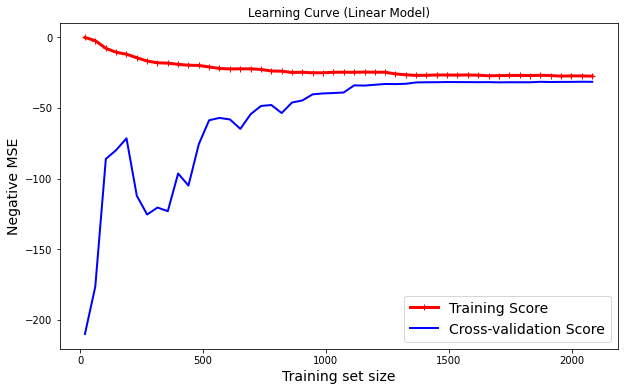

In [13]:
# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(Ridge(alpha=0.94, solver='sparse_cg'), X_train_poly, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                
                                                                                                                                                                                                                 
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

### SVM(RBF kernel) and Random Forrest

In [37]:
param_grid = {'gamma': [0.000001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'C': [10, 100, 1000, 10000]}



svm = SVR(kernel="rbf")

svm_cv = GridSearchCV(svm, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=2, n_jobs=-1)
svm_cv.fit(X, y)


params_optimal = svm_cv.best_params_

print("Best Score (negative mean squared error): %f" % svm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.7min finished


Best Score (negative mean squared error): -29.071563
Optimal Hyperparameter Values:  {'C': 10000, 'gamma': 0.0001}




In [38]:
svm = SVR(kernel="rbf", **params_optimal)
svm.fit(X_train, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_svm = svm.predict(X_train)


print("Train: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_svm))


# Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_svm))


# Make prediction using the test data
y_test_predicted_svm = svm.predict(X_test)

test_mse_svm = mean_squared_error(y_test, y_test_predicted_svm)

print("\nTest: Mean squared error: %.2f"
      % test_mse_svm)



# Explained variance score: 1 is perfect prediction

test_r2_svm = r2_score(y_test, y_test_predicted_svm)
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % test_r2_svm)


----------------------------- Model Evaluation -----------------------------
Train: Mean squared error: 34.97
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.70

Test: Mean squared error: 36.03
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.62


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [12]:
%%time
rnd_forest_reg = RandomForestRegressor()

dt_clf_cv = GridSearchCV(rnd_forest_reg, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
dt_clf_cv.fit(X_train, y_train)

params_optimal = dt_clf_cv.best_params_

print("Best Score (accuracy): %f" % dt_clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 43.4min finished


Best Score (accuracy): -27.227803
Optimal Hyperparameter Values:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1800}


Wall time: 44min 5s


In [13]:
 {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1800}

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1800}

In [15]:



rnd_forest_reg = RandomForestRegressor(**params_optimal,criterion="mse"
                                       ,verbose=1,
                                       oob_score=True, n_jobs=-1)

rnd_forest_reg.fit(X_train, y_train)


# Make prediction 
y_train_predicted_rnd_forest = rnd_forest_reg.predict(X_train)


train_mse_rnd_forest = mean_squared_error(y_train, y_train_predicted_rnd_forest)

print("Train: Mean squared error: %.2f"
      % train_mse_rnd_forest)


# Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_rnd_forest))




y_test_predicted_rnd_forest = rnd_forest_reg.predict(X_test)


test_mse_rnd_forest = mean_squared_error(y_test, y_test_predicted_rnd_forest)

print("Test: Mean squared error: %.2f"
      % test_mse_rnd_forest)


# Explained variance score: 1 is perfect prediction

test_r2_rnd_forest = r2_score(y_test, y_test_predicted_rnd_forest)


print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % test_r2_rnd_forest)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Do

Train: Mean squared error: 8.34
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.93


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s


Test: Mean squared error: 24.77
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.74


[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:    0.8s finished
